[INFO] Using device: cuda

=== Running experiment 1/20 ===

[INFO] Penalty 0.01

[INFO] loss_relative_diff: 1.0

[INFO] loss_relative_diff: 0.021872775611759057

[INFO] loss_relative_diff: 0.017942058595330965

[INFO] loss_relative_diff: 0.011427613212289809

[INFO] loss_relative_diff: 0.051047085352836016

[INFO] loss_relative_diff: 0.04070175494618501

[INFO] loss_relative_diff: 0.04219824877329344

[INFO] loss_relative_diff: 0.009149908365384965

[INFO] loss_relative_diff: 0.027350568673104116

[INFO] loss_relative_diff: 0.0010951446804135401

[INFO] Penalty 0.1

[INFO] loss_relative_diff: 1.0

[INFO] loss_relative_diff: 0.016321636240912776

[INFO] loss_relative_diff: 0.007530061311542623

[INFO] loss_relative_diff: 0.0020758566019340014

[INFO] loss_relative_diff: 0.00744970723208813

[INFO] loss_relative_diff: 0.0017146438456932206

[INFO] loss_relative_diff: 5.8413645051833655e-05

[INFO] loss_relative_diff: 5.295363227586905e-05

[INFO] loss_relative_diff: 0.0026135938910754686

KeyboardInterrupt: 

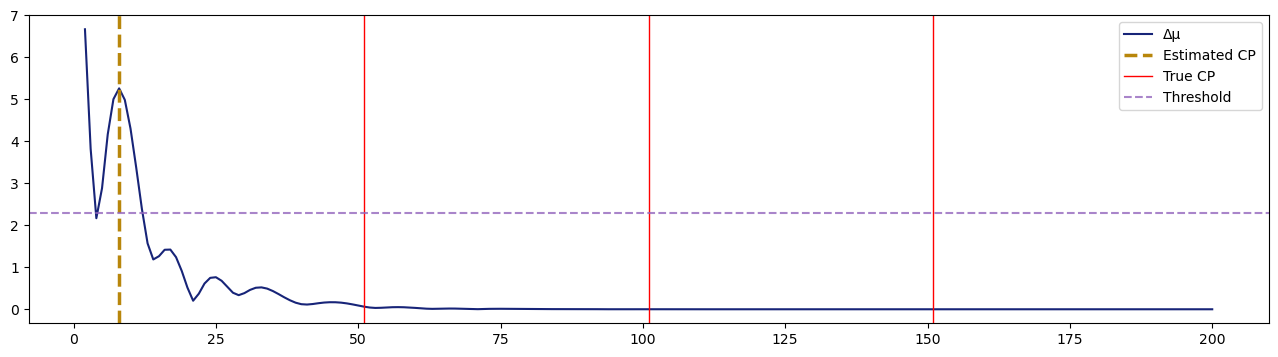

In [1]:
import torch
import numpy as np
import pandas as pd
from cpd_model import parse_args, learn_one_seq_penalty
"""
    parser = argparse.ArgumentParser()
    parser.add_argument('--z_dim', default=1, type=int) 
    parser.add_argument('--x_dim', default=3, type=int) 
    parser.add_argument('--y_dim', default=3, type=int)
    parser.add_argument('--K_dim', default=3, type=int)
    parser.add_argument('--output_layer', nargs='+', type=int, default=[128,128]) 
    parser.add_argument('--num_samples', default=100, type=int) 
    parser.add_argument('--num_time', default=200, type=int)
    parser.add_argument('--penalties', nargs='+', type=float, default=[0.01,0.1,0.5,1,10,100])
    parser.add_argument('--epoch', default=50, type=int)
    parser.add_argument('--decoder_lr', default=0.01, type=float)
    parser.add_argument('--langevin_K', default=100, type=int)
    parser.add_argument('--langevin_s', default=0.1, type=float)
    parser.add_argument('--kappa', default=0.1, type=float)
    parser.add_argument('--nu_iteration', default=20, type=int)
    parser.add_argument('--decoder_iteration', default=20, type=int)
    parser.add_argument('--loss_thr', default=1e-10, type=float)
    parser.add_argument('--iter_thr', default=5, type=int)
    parser.add_argument('--true_CP_full', nargs='+', type=int, default=[51,101,151])
    parser.add_argument('--signif_level', default=0.975, type=float)
    args, _ = parser.parse_known_args()
"""
args = parse_args()
args.epoch = 100           
args.penalties = [0.01, 0.1, 0.5, 1, 5] 
args.num_time = 200
args.num_samples = 100
args.x_dim = 3
args.y_dim = 3
args.z_dim = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Using device:", device)

all_results = []
n_repeats = 20 

for rep in range(n_repeats):
    print(f"\n=== Running experiment {rep+1}/{n_repeats} ===")


    dat_y = pd.read_csv(f"./reps_sim_dat/y_rep{rep}.csv").values
    dat_x = pd.read_csv(f"./reps_sim_dat/x_rep{rep}.csv").values


    T, N, dx, dy = args.num_time, args.num_samples, args.x_dim, args.y_dim
    Y_array = dat_y.T.reshape(dy, N, T, order="F").transpose(2,1,0)
    X_array = dat_x.T.reshape(dx, N, T, order="F").transpose(2,1,0)


    x_input = torch.tensor(X_array, dtype=torch.float32).to(device)
    y_input = torch.tensor(Y_array, dtype=torch.float32).to(device)


    odd_idx, even_idx = range(1, T, 2), range(0, T, 2)
    x_train, x_test = x_input[odd_idx].reshape(-1, dx), x_input[even_idx].reshape(-1, dx)
    y_train, y_test = y_input[odd_idx].reshape(-1, dy), y_input[even_idx].reshape(-1, dy)


    results_half = []
    for penalty in args.penalties:
        loss, pen = learn_one_seq_penalty(args, x_train, y_train,
                                          x_test, y_test,
                                          penalty=penalty,
                                          half=True)
        results_half.append([loss, pen])
    results_half = np.array(results_half)

    best_idx = np.argmin(results_half[:, 0])
    best_penalty = args.penalties[best_idx]
    print(f"[INFO] rep {rep} best penalty={best_penalty}")

 
    res_full = learn_one_seq_penalty(
        args,
        x_input.reshape(-1, dx),
        y_input.reshape(-1, dy),
        x_input.reshape(-1, dx),
        y_input.reshape(-1, dy),
        penalty=best_penalty,
        half=False
    )

    all_results.append({
        "rep": rep,
        "results_half": results_half.tolist(),
        "best_penalty": best_penalty,
        "res_full": res_full
    })


df_results = pd.DataFrame(all_results)
# df_results.to_pickle("exp_results.pkl")
# print("\n[INFO] Saved all results to exp_results.pkl")
df_results["res_full"].apply(lambda x: x[3]).mean()